**SETA - Q1**

Epoch [1/5], Step [1/235], Loss: 0.2799
Epoch [1/5], Step [101/235], Loss: 0.0352
Epoch [1/5], Step [201/235], Loss: 0.0262
Epoch [2/5], Step [1/235], Loss: 0.0251
Epoch [2/5], Step [101/235], Loss: 0.0211
Epoch [2/5], Step [201/235], Loss: 0.0185
Epoch [3/5], Step [1/235], Loss: 0.0185
Epoch [3/5], Step [101/235], Loss: 0.0160
Epoch [3/5], Step [201/235], Loss: 0.0143
Epoch [4/5], Step [1/235], Loss: 0.0136
Epoch [4/5], Step [101/235], Loss: 0.0130
Epoch [4/5], Step [201/235], Loss: 0.0118
Epoch [5/5], Step [1/235], Loss: 0.0114
Epoch [5/5], Step [101/235], Loss: 0.0101
Epoch [5/5], Step [201/235], Loss: 0.0097


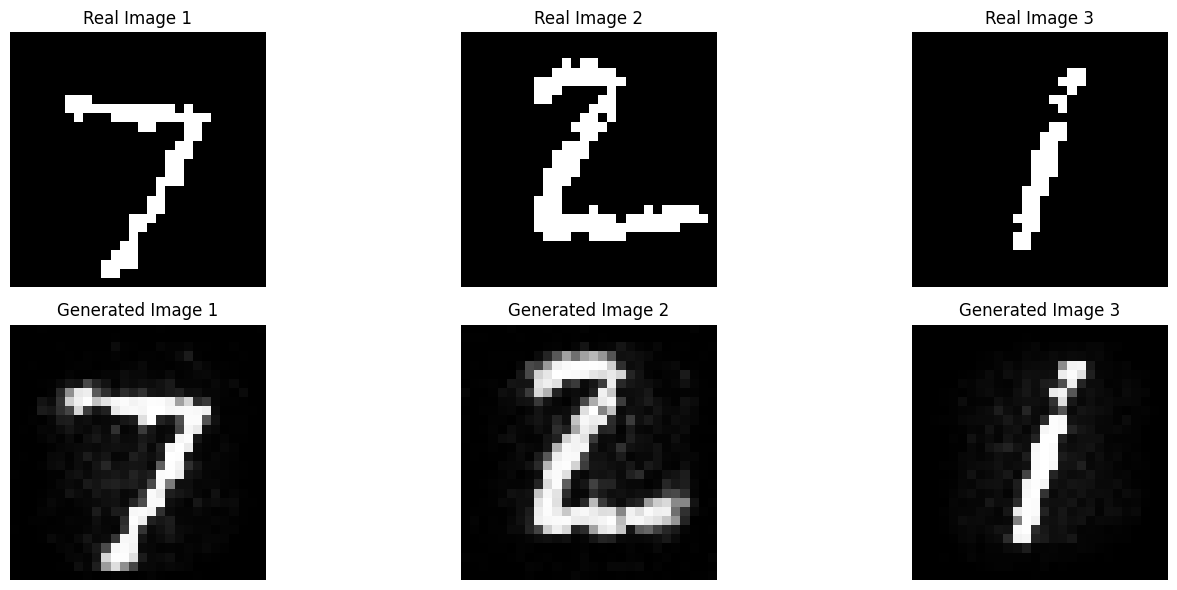

In [20]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set hyperparameters
batch_size = 256
num_epochs = 5
learning_rate = 0.001
num_visible = 784
num_hidden = 512

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define RBM model
class RBM(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(num_visible, num_hidden) * 0.1)
        self.v_bias = nn.Parameter(torch.zeros(num_visible))
        self.h_bias = nn.Parameter(torch.zeros(num_hidden))

    def sample_h(self, x):
        wx = torch.matmul(x, self.W) + self.h_bias
        return torch.sigmoid(wx)

    def sample_v(self, h):
        wh = torch.matmul(h, self.W.t()) + self.v_bias
        return torch.sigmoid(wh)

    def forward(self, x):
        h = self.sample_h(x)
        return h

# Initialize RBM model, loss function, and optimizer
model = RBM(num_visible, num_hidden).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(device)
        x = x.bernoulli()  # Convert to binary

        # Contrastive Divergence (CD) algorithm
        h = model.sample_h(x)
        x_recon = model.sample_v(h)
        h_recon = model.sample_h(x_recon)

        # Calculate loss
        loss = criterion(x, x_recon)

        # Backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss at each 100 mini-batches
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Generate new images
model.eval()
with torch.no_grad():
    test_images = next(iter(test_loader))[0].view(-1, 28*28).to(device)
    test_images = test_images.bernoulli()
    generated_images = model.sample_v(torch.sigmoid(torch.matmul(test_images, model.W) + model.h_bias))

# Visualize real and generated images
num_images = 3
fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(15, 6))

for i in range(num_images):
    # Plot real images
    axes[0, i].imshow(test_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f'Real Image {i+1}')
    axes[0, i].axis('off')

    # Plot generated images
    axes[1, i].imshow(generated_images[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title(f'Generated Image {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

**SETB - Q3**

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define RBM model
class RBM(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(num_visible, num_hidden) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(num_hidden))
        self.v_bias = nn.Parameter(torch.zeros(num_visible))

    def sample_h(self, v):
        h_prob = torch.sigmoid(torch.matmul(v, self.W) + self.h_bias)
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        v_prob = torch.sigmoid(torch.matmul(h, self.W.t()) + self.v_bias)
        return v_prob, torch.bernoulli(v_prob)

    def forward(self, v):
        h_prob, h_sample = self.sample_h(v)
        return h_prob

# Define DBN model
class DBN(nn.Module):
    def __init__(self, num_visible, num_hidden_layers, num_hidden_units):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([RBM(num_visible, num_hidden_units)] +
                                  [RBM(num_hidden_units, num_hidden_units) for _ in range(num_hidden_layers - 1)])

    def forward(self, x):
        for rbm in self.rbms:
            x = rbm(x)
        return x

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize DBN model and optimizer
num_visible = 784
num_hidden_layers = 3
num_hidden_units = 256
dbn = DBN(num_visible, num_hidden_layers, num_hidden_units)
optimizer = optim.SGD(dbn.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch in train_loader:
        data, _ = batch
        data = data.view(-1, num_visible)

        # Train each RBM in the DBN
        for i, rbm in enumerate(dbn.rbms):
            if i == 0:
                input_data = data
            else:
                input_data = dbn.rbms[i-1](input_data).detach()

            # Positive phase
            h_prob = rbm(input_data)

            # Negative phase
            v_prob, v_sample = rbm.sample_v(h_prob)
            h_prob_recon = rbm(v_sample)

            # Calculate loss
            loss = torch.mean(torch.sum(input_data * torch.log(v_prob) + (1 - input_data) * torch.log(1 - v_prob), 1))

            # Backpropagate and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {-loss.item():.4f}')

# Fine-tune DBN with a classifier
class Classifier(nn.Module):
    def __init__(self, num_hidden_units, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(num_hidden_units, num_classes)

    def forward(self, x):
        return self.fc(x)

classifier = Classifier(num_hidden_units, 10)
optimizer = optim.SGD(classifier.parameters(), lr=0.01)

# Fine-tuning loop
num_epochs = 50
for epoch in range(num_epochs):
    for batch in train_loader:
        data, labels = batch
        data = data.view(-1, num_visible)

        # Forward pass through DBN
        features = dbn(data)

        # Forward pass through classifier
        logits = classifier(features)
        loss = nn.CrossEntropyLoss()(logits, labels)

        # Backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Evaluate DBN with classifier
dbn.eval()
classifier.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for batch in test_loader:
        data, labels = batch
        data = data.view(-1, num_visible)

        # Forward pass through DBN
        features = dbn(data)

        # Forward pass through classifier
        logits = classifier(features)
        loss = nn.CrossEntropyLoss()(logits, labels)
        test_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()

accuracy = correct / len(test_dataset)
print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {accuracy:.4f}')


# Save the trained DBN and classifier models
torch.save(dbn.state_dict(), 'dbn_model.pth')
torch.save(classifier.state_dict(), 'classifier_model.pth')


# Load the saved DBN and classifier models
dbn.load_state_dict(torch.load('dbn_model.pth'))
classifier.load_state_dict(torch.load('classifier_model.pth'))


# Use the trained DBN and classifier for making predictions
def make_prediction(image):
    image = image.view(-1, 784)
    feature = dbn(image)
    logits = classifier(feature)
    _, predicted = torch.max(logits, 1)
    return predicted


# Test the prediction function
test_image, test_label = test_dataset[0]
predicted_label = make_prediction(test_image)
print(f'Predicted Label: {predicted_label}, Actual Label: {test_label}')


# Visualize the learned features
def visualize_features():
    weights = dbn.rbms[0].W
    plt.figure(figsize=(10, 10))
    for i in range(100):
        plt.subplot(10, 10, i+1)
        plt.imshow(weights[i].view(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()


visualize_features()

RuntimeError: Expected p_in >= 0 && p_in <= 1 to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)